In [1]:
import nibabel as nib
import numpy as np
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.padding import PKCS7
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import logging
import pyspark
from nibabel.filebasedimages import FileBasedImage
import cv2
import pandas as pd
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
CT_SCANS = "../rawdata/ct_scans"
INFECTION_MASKS = "../rawdata/infection_mask"
LUNGANDINFECTION_MASKS = "../rawdata/lung_and_infection_mask"
LUNG_MASKS = "../rawdata/lung_mask"
OUTPUT_DIR = "../rawdata/"

In [5]:
ct_nii: FileBasedImage = nib.load(f"{CT_SCANS}/coronacases_org_001.nii")
header = ct_nii.header
affine = ct_nii.affine
data = ct_nii.get_fdata()
data = np.array(data)
data[0], np.min(data), np.max(data), data.shape

(array([[-998., -998., -999., ..., -998., -998., -998.],
        [-998., -998., -999., ..., -998., -998., -998.],
        [-998., -998., -999., ..., -998., -998., -998.],
        ...,
        [-998., -999., -998., ..., -998., -998., -998.],
        [-998., -999., -998., ..., -998., -998., -998.],
        [-998., -999., -998., ..., -998., -998., -998.]]),
 np.float64(-1021.0),
 np.float64(2996.0),
 (512, 512, 301))

In [ ]:
spark = SparkSession.builder \
    .appName("NIfTI_Processing") \
    .config("spark.executor.memory", "4") \
    .config("spark.driver.memory", "4") \
    .config("spark.driver.maxResultSize", "4") \
    .getOrCreate()
sc = spark.sparkContext

24/12/07 19:34:10 WARN Utils: Your hostname, SerVer resolves to a loopback address: 127.0.1.1; using 192.168.1.250 instead (on interface enp3s0f0)
24/12/07 19:34:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 19:34:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load into RDDs

In [ ]:
##### Extract #####
def extract_metadata():
    # Extract metadata from the downloaded dataset
    path = os.path.join(OUTPUT_DIR, "metadata.csv")
    metadata = pd.read_csv(path)
    logger.info("Metadata extracted successfully!")
    metadata.replace("../input/covid19-ct-scans/", "", regex=True, inplace=True)
    return metadata

def extract_image_data(metadata: pd.DataFrame):
    # Convert DataFrame to np array
    image_paths: np.ndarray = metadata.to_numpy().flatten()
    # Extract image data
    def load_image(x):
        path = os.path.join(OUTPUT_DIR, x)
        nifti_data = nib.load(path)
        header = nifti_data.header
        affine = nifti_data.affine
        image_data = nifti_data.get_fdata()
        image_data = np.array(image_data)

        return image_data, header, affine, x

    image_rdds = sc.parallelize(image_paths).map(load_image)

    return image_rdds

def save_image_data(image_rdds: pyspark.rdd.PipelinedRDD):
    # Save image data to disk
    def save_image(x):
        image_data, header, affine, file_name = x
        nifti_data = nib.Nifti1Image(image_data, affine, header)
        os.makedirs("output", exist_ok=True)
        folder = file_name.split("/")[0]
        os.makedirs(f"output/{folder}", exist_ok=True)
        nifti_data.to_filename(f"output/{file_name}")

    image_rdds.foreach(save_image)

In [ ]:
##### Transform #####

# Resize the image's x and y dimensions to 256x256
def resize_image(image_rdds: pyspark.rdd.PipelinedRDD):
    def resize_image(x):
        image_data, header, affine, file_name = x
        resized_image = cv2.resize(image_data, (256, 256))
        return resized_image, header, affine, file_name
    
    resized_image_rdds = image_rdds.map(resize_image)
    logger.info("Image resized successfully!")
    return resized_image_rdds

# Normalize the image data
def normalize_image(image_rdds: pyspark.rdd.PipelinedRDD):
    def normalize_image(x):
        image_data, header, affine, file_name = x
        normalized_image = cv2.normalize(image_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return normalized_image, header, affine, file_name

    normalized_image_rdds = image_rdds.map(normalize_image)
    logger.info("Image normalized successfully!")
    return normalized_image_rdds

# Noice reduction
def denoise_image(image_rdds: pyspark.rdd.PipelinedRDD):
    def denoise_image(x):
        image_data, header, affine, file_name = x
        denoised_image = cv2.fastNlMeansDenoising(image_data, None, 10, 7, 21)
        return denoised_image, header, affine, file_name

    denoised_image_rdds = image_rdds.map(denoise_image)
    logger.info("Image denoised successfully!")
    return denoised_image_rdds

In [35]:
##### Load #####
# Save to disk
def save_data(image_rdds: pyspark.rdd.PipelinedRDD):
    def save_image(x):
        image_data, header, affine, file_name = x
        print(f"Saving image: {file_name}")
        # Save image data: np array to disk
        os.makedirs("output", exist_ok=True)
        folder = file_name.split("/")[0]
        os.makedirs(f"output/{folder}", exist_ok=True)
        image_data = np.array(image_data)
        np.save(f"output/{file_name}", image_data)

    image_rdds.foreach(save_image)

In [ ]:
metadata = extract_metadata()
rdds = extract_image_data(metadata)
rdds = resize_image(rdds)
rdds = normalize_image(rdds)
rdds = denoise_image(rdds)
save_data(rdds)

INFO:__main__:Metadata extracted successfully!
24/12/07 20:24:09 ERROR Executor: Exception in task 66.0 in stage 11.0 (TID 858)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", li

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 66 in stage 11.0 failed 1 times, most recent failure: Lost task 66.0 in stage 11.0 (TID 858) (192.168.1.250 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  [Previous line repeated 1 more time]
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 840, in func
    return f(iterator)
           ^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 1762, in processPartition
    for x in iterator:
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2196850/1158716730.py", line 27, in denoise_image
cv2.error: OpenCV(4.10.0) /io/opencv/modules/photo/src/denoising.cpp:141: error: (-5:Bad argument) Unsupported depth! Only CV_8U is supported for NORM_L2 in function 'fastNlMeansDenoising'


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split, iterator))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  [Previous line repeated 1 more time]
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 840, in func
    return f(iterator)
           ^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 1762, in processPartition
    for x in iterator:
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2196850/1158716730.py", line 27, in denoise_image
cv2.error: OpenCV(4.10.0) /io/opencv/modules/photo/src/denoising.cpp:141: error: (-5:Bad argument) Unsupported depth! Only CV_8U is supported for NORM_L2 in function 'fastNlMeansDenoising'


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


24/12/07 20:24:10 WARN TaskSetManager: Lost task 70.0 in stage 11.0 (TID 862) (192.168.1.250 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 66 in stage 11.0 failed 1 times, most recent failure: Lost task 66.0 in stage 11.0 (TID 858) (192.168.1.250 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split,

24/12/07 20:24:11 WARN TaskSetManager: Lost task 52.0 in stage 11.0 (TID 844) (192.168.1.250 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 66 in stage 11.0 failed 1 times, most recent failure: Lost task 66.0 in stage 11.0 (TID 858) (192.168.1.250 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1237, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aphuc/web/data_science/pytorch-notebook/ETL-MI/.venv/lib/python3.12/site-packages/pyspark/rdd.py", line 5434, in pipeline_func
    return func(split, prev_func(split,

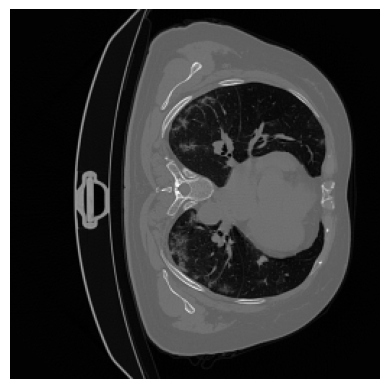

In [28]:
# Load a sample from the saved data
loaded_data = np.load("output/ct_scans/coronacases_org_001.nii.npy")
import matplotlib.pyplot as plt

middle_slice = loaded_data.shape[2] // 2
plt.imshow(loaded_data[:,:,middle_slice], cmap="gray")
plt.axis("off")
plt.show()

## Encrypted Data

In [ ]:
def encrypt_nifti(file_path, password, output_path):
    # Read the NIfTI image
    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    header = nifti_img.header
    
    # Serialize the data to bytes
    data_bytes = data.tobytes()

    # Derive a key from the password
    salt = os.urandom(16)  # Generate a random salt
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=100000,
        backend=default_backend()
    )
    key = kdf.derive(password.encode())  # Derive the key

    # Encrypt the data
    iv = os.urandom(16)  # Initialization vector
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    
    # Padding for block cipher
    padder = PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data_bytes) + padder.finalize()

    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()

    # Save the encrypted data and metadata
    with open(output_path, 'wb') as f:
        f.write(salt)  # Write salt for key derivation
        f.write(iv)    # Write IV for decryption
        f.write(encrypted_data)  # Write encrypted data

    print(f"Encrypted NIfTI image saved to {output_path}")

In [ ]:
encrypt_nifti(f"{CT_SCANS}/coronacases_org_001.nii", "258456C@p", "encrypted.nii")

Encrypted NIfTI image saved to encrypted.nii
